In [ ]:
# import tensorflow as tf

# print("TensorFlow version:", tf.__version__)
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     print("GPU(s) found:")
#     for gpu in gpus:
#         print("  ", gpu)
# else:
#     print("No GPU found. Please check your CUDA/cuDNN installation.")

# if tf.config.list_physical_devices('GPU'):
#     print("GPU is available.")
# else:
#     print("GPU is not available.")


2025-04-16 14:04:49.943733: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 14:04:49.951317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744797889.959347  127315 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744797889.961672  127315 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744797889.968842  127315 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
GPU(s) found:
   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU is available.


In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

print("TensorFlow Version:", tf.__version__)
print("GPUs Available:", gpus)


2025-04-16 14:36:16.073022: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 14:36:16.107218: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-16 14:36:16.872318: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow Version: 2.20.0-dev20250413
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
from transformers import AutoProcessor, AutoModel
import torch
import requests
from PIL import Image

# Load the SigLIP2 model and processor
model_name = "google/siglip2-base-patch16-224"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()  # Set model to evaluation mode

# Example: load an image from a URL
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Get the image embeddings without the logits
# The get_image_features method returns the embeddings produced by the vision encoder
with torch.no_grad():
    image_features = model.get_image_features(**inputs)

print("Image features shape:", image_features.shape)

Image features shape: torch.Size([1, 768])


In [6]:
import os
from PIL import Image
import numpy as np
import torch

# Ensure your model and processor are initialized beforehand and moved to GPU
model.to('cuda')


def process_video_frames(video_folder, max_frames=196, embedding_dim=768):
    frame_files = sorted([
        os.path.join(video_folder, f)
        for f in os.listdir(video_folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])

    frame_files = frame_files[:max_frames]

    embeddings = []
    for frame_file in frame_files:
        image = Image.open(frame_file).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to('cuda')

        with torch.no_grad():
            image_features = model.get_image_features(**inputs)

        embeddings.append(image_features.squeeze(0).cpu().numpy())

    while len(embeddings) < max_frames:
        embeddings.append(np.zeros(embedding_dim))

    return np.stack(embeddings)


In [8]:
import glob
import tensorflow as tf
import pandas as pd
import numpy as np
import os

# Load target values from CSV
target_df = pd.read_csv('final_data.csv')

video_dirs = glob.glob("video_frames/*")
dataset = []
targets = []

for video_dir in video_dirs:
    video_id = os.path.basename(video_dir)
    
    # Check if video_id exists in the loaded CSV
    if video_id in target_df['video_id'].values:
        embedding_tensor = process_video_frames(video_dir)
        dataset.append(embedding_tensor)

        # Fetch corresponding target value
        target_value = target_df.loc[target_df['video_id'] == video_id, 'transformed_engagement_score'].values[0]
        targets.append(target_value)
    else:
        print(f"Warning: video_id {video_id} not found in CSV. Skipping.")

# Convert to NumPy arrays
dataset = np.stack(dataset)  # Shape: (num_matched_videos, 196, 768)
targets = np.array(targets)  # Shape: (num_matched_videos,)

# Convert NumPy arrays to TensorFlow tensors
tf_dataset = tf.convert_to_tensor(dataset, dtype=tf.float32)
tf_targets = tf.convert_to_tensor(targets, dtype=tf.float32)

# Save dataset and targets
np.save("video_dataset.npy", tf_dataset)
np.save("video_targets.npy", tf_targets)


I0000 00:00:1744796918.160499    8834 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12628 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:85:00.0, compute capability: 8.9


In [ ]:
# from transformers import AutoTokenizer, AutoModel
# import torch
# import numpy as np

# # Load the pretrained tokenizer and encoder
# model_name = "sentence-transformers/all-mpnet-base-v2"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

# # Example input texts
# texts = [
#     "A small brown fox jumps over the lazy dog near the river bank.",
#     "An astronaut standing on the moon with Earth visible in the sky."
# ]

# # Tokenize inputs (padding, truncation)
# encoded = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

# # Generate embeddings (no gradient needed)
# with torch.no_grad():
#     model_output = model(**encoded)

# # Mean pooling (recommended)
# token_embeddings = model_output.last_hidden_state
# attention_mask = encoded['attention_mask'].unsqueeze(-1).expand(token_embeddings.size())
# sum_embeddings = torch.sum(token_embeddings * attention_mask, dim=1)
# valid_token_counts = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
# sentence_embeddings = sum_embeddings / valid_token_counts  # shape: (batch_size, 768)

# # Convert to numpy and save
# embeddings_np = sentence_embeddings.cpu().numpy()
# np.save("text_embeddings_768.npy", embeddings_np)

# print("Saved embeddings shape:", embeddings_np.shape)


In [7]:
import glob
import tensorflow as tf
import numpy as np
import pandas as pd

# Load CSV metadata to obtain IDs
metadata_df = pd.read_csv('metadata.csv')  # assuming CSV has columns ['ID', 'text']

video_dataset = []
text_dataset = []

# Initialize text embedding model
from transformers import AutoTokenizer, AutoModel
import torch

model_name = "sentence-transformers/all-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Process data based on IDs
for idx, row in metadata_df.iterrows():
    video_id = row['ID']
    text = row['text']

    # --- Video Embedding ---
    video_dir = f"video_frames/{video_id}"
    video_embedding_tensor = process_video_frames(video_dir)  # shape: (196, 768)
    video_dataset.append(video_embedding_tensor)

    # --- Text Embedding ---
    encoded_text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')

    with torch.no_grad():
        model_output = model(**encoded_text)

    token_embeddings = model_output.last_hidden_state
    attention_mask = encoded_text['attention_mask'].unsqueeze(-1).expand(token_embeddings.size())
    sum_embeddings = torch.sum(token_embeddings * attention_mask, dim=1)
    valid_token_counts = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
    sentence_embedding = sum_embeddings / valid_token_counts  # shape: (1, 768)

    text_dataset.append(sentence_embedding.squeeze().cpu().numpy())

# Convert to NumPy arrays
video_dataset = np.stack(video_dataset)  # shape: (num_videos, 196, 768)
text_dataset = np.stack(text_dataset)    # shape: (num_texts, 768)

# Save datasets
np.save("video_dataset.npy", video_dataset)
np.save("text_dataset.npy", text_dataset)

print("Saved video embeddings shape:", video_dataset.shape)
print("Saved text embeddings shape:", text_dataset.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'metadata.csv'

In [ ]:
# import tensorflow as tf
# from transformers import TFViTModel

# # 1. Define input for a sequence of 196 frame embeddings (each 768-D)
# frame_seq_input = tf.keras.Input(shape=(196, 768), dtype=tf.float32, name="frame_sequence")

# # 2. Linear projection layer to match ViT Tiny's embedding size (192)
# proj_layer = tf.keras.layers.Dense(192, name="proj_768_to_192")
# projected_seq = proj_layer(frame_seq_input)  # shape: (batch_size, 196, 192)

# # 3. Load pre-trained ViT Tiny model (no classification head)
# vit_base = TFViTModel.from_pretrained('facebook/deit-tiny-patch16-224')

# # 4. Pass projected embeddings to ViT model using the `inputs_embeds` argument
# outputs = vit_base(inputs_embeds=projected_seq)
# # `outputs.last_hidden_state` has shape (batch_size, 197, 192) -> includes CLS token at index 0
# cls_output = outputs.last_hidden_state[:, 0, :]   # shape: (batch_size, 192)

# # # 5. Regression head: predict 2 continuous values from CLS representation
# # regression_output = tf.keras.layers.Dense(2, name="regression_head")(cls_output)

# # # 6. Build and compile the model
# # regression_model = tf.keras.Model(inputs=frame_seq_input, outputs=regression_output)
# # regression_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
# # regression_model.summary()

In [ ]:
# from transformers import TFViTModel, ViTConfig
# import tensorflow as tf

# class TFViTWithEmbeddingsInput(TFViTModel):
#     def __init__(self, config: ViTConfig, **kwargs):
#         super().__init__(config, **kwargs)

#     def call(
#         self,
#         inputs_embeds: tf.Tensor = None,
#         head_mask=None,
#         output_attentions=None,
#         output_hidden_states=None,
#         interpolate_pos_encoding=None,
#         return_dict=True,
#         training=False,
#     ):
#         if inputs_embeds is None:
#             raise ValueError("You have to specify inputs_embeds")

#         batch_size = tf.shape(inputs_embeds)[0]

#         # Add [CLS] token
#         cls_token = tf.broadcast_to(self.vit.embeddings.cls_token, [batch_size, 1, self.config.hidden_size])
#         embeddings = tf.concat([cls_token, inputs_embeds], axis=1)

#         # Add positional embeddings
#         position_embeddings = self.vit.embeddings.position_embeddings
#         embeddings += position_embeddings

#         embeddings = self.vit.embeddings.dropout(embeddings, training=training)

#         # Encoder
#         encoder_outputs = self.vit.encoder(
#             hidden_states=embeddings,
#             head_mask=head_mask or [None] * self.config.num_hidden_layers,
#             output_attentions=output_attentions,
#             output_hidden_states=output_hidden_states,
#             return_dict=return_dict,
#             training=training,
#         )

#         sequence_output = encoder_outputs[0]
#         sequence_output = self.vit.layernorm(sequence_output)
#         pooled_output = self.vit.pooler(sequence_output) if self.vit.pooler else None

#         if not return_dict:
#             return (sequence_output, pooled_output) + encoder_outputs[1:]

#         return {
#             "last_hidden_state": sequence_output,
#             "pooler_output": pooled_output,
#             "hidden_states": encoder_outputs.hidden_states,
#             "attentions": encoder_outputs.attentions,
#         }



# class TFViTEmbeddingsLayer(tf.keras.layers.Layer):
#     def __init__(self, model_name='facebook/deit-tiny-patch16-224', **kwargs):
#         super().__init__(**kwargs)
#         config = ViTConfig.from_pretrained(model_name)
#         self.vit_base = TFViTWithEmbeddingsInput.from_pretrained(model_name, config=config)

#     def call(self, inputs_embeds):
#         outputs = self.vit_base(inputs_embeds=inputs_embeds)
#         return outputs['last_hidden_state'][:, 0, :]  # CLS token output


In [4]:
import tensorflow as tf
from transformers.modeling_tf_utils import TFPreTrainedModel
from transformers.models.vit.configuration_vit import ViTConfig
from transformers.models.vit.modeling_tf_vit import TFViTPreTrainedModel, TFViTEncoder
from transformers.modeling_tf_outputs import TFBaseModelOutput

class TFViTMainEmbeddingsInput(tf.keras.layers.Layer):
    """Main ViT layer that accepts external patch embeddings (no image patch projection)."""
    def __init__(self, config: ViTConfig, **kwargs):
        super().__init__(**kwargs)
        # Compute number of patch tokens from image_size and patch_size
        image_size = config.image_size if isinstance(config.image_size, tuple) else (config.image_size, config.image_size)
        patch_size = config.patch_size if isinstance(config.patch_size, tuple) else (config.patch_size, config.patch_size)
        num_patches = (image_size[0] // patch_size[0]) * (image_size[1] // patch_size[1])
        self.config = config

        # Learned embeddings: CLS token and positional encodings
        self.cls_token = self.add_weight(
            shape=(1, 1, config.hidden_size),
            initializer=tf.keras.initializers.RandomNormal(stddev=config.initializer_range),
            trainable=True,
            name="cls_token"
        )
        self.position_embeddings = self.add_weight(
            shape=(1, num_patches + 1, config.hidden_size),
            initializer=tf.keras.initializers.RandomNormal(stddev=config.initializer_range),
            trainable=True,
            name="position_embeddings"
        )
        # Dropout layer for embeddings
        self.dropout = tf.keras.layers.Dropout(rate=config.hidden_dropout_prob)
        # Transformer encoder (multi-layer ViT encoder from Hugging Face)
        self.encoder = TFViTEncoder(config, name="encoder")
        # Final layer normalization
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=config.layer_norm_eps, name="layernorm")
        # Note: No pooler layer is used

    def call(self, patch_embeddings: tf.Tensor, output_attentions: bool=False, 
             output_hidden_states: bool=False, return_dict: bool=True, training: bool=False) -> TFBaseModelOutput:
        """
        Forward pass with external patch embeddings.
        Args:
          patch_embeddings: Tensor of shape (batch_size, 196, hidden_size) containing patch embeddings.
        Returns:
          TFBaseModelOutput if return_dict=True (default) with fields:
            - last_hidden_state: [batch_size, 197, hidden_size]
            - hidden_states: tuple of tf.Tensor (optional, if output_hidden_states=True)
            - attentions: tuple of tf.Tensor (optional, if output_attentions=True)
          Or a tuple: (last_hidden_state, hidden_states, attentions) if return_dict=False.
        """
        # Append the [CLS] token to the patch embeddings
        batch_size = tf.shape(patch_embeddings)[0]
        cls_tokens = tf.repeat(self.cls_token, repeats=batch_size, axis=0)  # shape (batch_size, 1, hidden_size)
        embeddings = tf.concat([cls_tokens, patch_embeddings], axis=1)      # shape (batch_size, 197, hidden_size)

        # Add absolute positional embeddings (index 0 = CLS position, 1-196 = patch positions)
        embeddings = embeddings + self.position_embeddings

        # Apply dropout to embeddings
        embeddings = self.dropout(embeddings, training=training)

        # No attention mask (sequence is fixed-length with no padding)
        head_mask = [None] * self.config.num_hidden_layers

        # Pass through the Transformer encoder
        encoder_outputs = self.encoder(
            hidden_states=embeddings,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            training=training
        )

        # The encoder outputs last hidden state (before layer norm) as either tuple or ModelOutput
        if return_dict:
            # `TFViTEncoder` returns TFBaseModelOutput (last_hidden_state, optional hidden_states, attentions)
            encoder_last_hidden = encoder_outputs.last_hidden_state  # shape (batch_size, 197, hidden_size)
            all_hidden_states = encoder_outputs.hidden_states
            all_attentions = encoder_outputs.attentions
        else:
            # Tuple format: (last_hidden_state, hidden_states?, attentions?)
            encoder_last_hidden = encoder_outputs[0]
            all_hidden_states = encoder_outputs[1] if output_hidden_states else None
            # If only attentions were requested (no hidden_states), attentions tuple is at index 1
            if output_attentions and not output_hidden_states:
                all_attentions = encoder_outputs[1]
            elif output_attentions and output_hidden_states:
                all_attentions = encoder_outputs[2]
            else:
                all_attentions = None

        # Apply final layer normalization to the last hidden state
        sequence_output = self.layernorm(encoder_last_hidden)  # shape (batch_size, 197, hidden_size)

        if not return_dict:
            # Return as tuple
            outputs: tuple = (sequence_output,)
            if output_hidden_states:
                outputs += (all_hidden_states,)
            if output_attentions:
                outputs += (all_attentions,)
            return outputs
        # Return as TFBaseModelOutput (dataclass)
        return TFBaseModelOutput(last_hidden_state=sequence_output, hidden_states=all_hidden_states, attentions=all_attentions)


class TFViTWithEmbeddingsInput(TFViTPreTrainedModel):
    """
    Vision Transformer model that accepts external patch embeddings (bypassing image patch projection).
    This model is based on DeiT-tiny (ViT patch16-224) and is compatible with its pre-trained weights.
    """
    def __init__(self, config: ViTConfig, **kwargs):
        super().__init__(config, **kwargs)
        # Main ViT layers (embeddings + encoder + layernorm), no pooling layer
        self.vit = TFViTMainEmbeddingsInput(config, name="vit")

    def call(self, patch_embeddings: tf.Tensor, 
             output_attentions: bool=None, output_hidden_states: bool=None, 
             return_dict: bool=None, training: bool=False):
        # Set default values for output_attentions, output_hidden_states, return_dict from config if not provided
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        return_dict = return_dict if return_dict is not None else self.config.return_dict

        # Forward to the main vit layer
        outputs = self.vit(
            patch_embeddings=patch_embeddings,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            training=training
        )
        return outputs  # TFBaseModelOutput or tuple as per return_dict


class TFViTEmbeddingsLayer(tf.keras.layers.Layer):
    """
    Keras layer wrapper for TFViTWithEmbeddingsInput, which directly outputs the last hidden state.
    This can be used to integrate the ViT encoder into a broader model.
    """
    def __init__(self, model_name: str = "facebook/deit-tiny-patch16-224", **kwargs):
        super().__init__(**kwargs)
        # Load the pre-trained DeiT-tiny model into our custom TFViTWithEmbeddingsInput
        self.vit_model = TFViTWithEmbeddingsInput.from_pretrained(model_name)

    def call(self, patch_embeddings: tf.Tensor, training: bool=False) -> tf.Tensor:
        # Run the ViT model on the input patch embeddings and get the last hidden state
        # We ensure we only return the last hidden state (all tokens, including CLS as the first token)
        outputs = self.vit_model(patch_embeddings, training=training, 
                                  output_attentions=False, output_hidden_states=False, return_dict=False)
        # outputs will be a tuple (last_hidden_state,) since we disabled hidden_states and attentions
        last_hidden_state = outputs[0]
        return last_hidden_state


In [5]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout, Activation, Flatten
# from tensorflow.keras.models import Model
# from transformers import TFViTModel

# # 1. Define input for a sequence of 196 frame embeddings (each 768-D)
# frame_seq_input = tf.keras.Input(shape=(196, 768), dtype=tf.float32, name="frame_sequence")

# # 2. Linear projection layer to match ViT Tiny's embedding size (192)
# proj_layer = tf.keras.layers.Dense(192, name="proj_768_to_192")
# projected_seq = proj_layer(frame_seq_input)  # shape: (batch_size, 196, 192)

# # 3. Load pre-trained ViT Tiny model (no classification head)
# # vit_base = TFViTModel.from_pretrained('facebook/deit-tiny-patch16-224')


# # Initialize the layer (once, usually at the top of your model definition)
# vit_embeddings_layer = TFViTEmbeddingsLayer(model_name="facebook/deit-tiny-patch16-224")

# # Use it within the Keras functional API
# vit_output = vit_embeddings_layer(projected_seq, training=True)

# # Extract the CLS token embedding (first token)
# vit_cls_embedding = vit_output[:, 0, :]  # shape: (batch_size, hidden_size)

# # `outputs.last_hidden_state` has shape (batch_size, 197, 192) -> includes CLS token at index 0
# # vit_cls_embedding = outputs.last_hidden_state[:, 0, :]   # shape: (batch_size, 192)
# # vit_cls_embedding = vit_cls_embedding.last_hidden_state[:, 0, :]

# # Define two inputs for text embeddings
# text_input   = tf.keras.Input(shape=(768,), dtype=tf.float32, name="text_input")
# # text_input   = Input(shape=(768,), name="text_input")

# # Project each input independently to 64 dimensions
# visual_proj = Dense(64, activation='relu')(vit_cls_embedding)
# text_proj   = Dense(64, activation='relu')(text_input)

# # Concatenate the two 64-d projections -> resulting 128-d vector
# combined = Concatenate()([visual_proj, text_proj])

# # Hidden layer: Dense -> BatchNorm -> Dropout -> ReLU
# hidden = Dense(64, use_bias=True)(combined)           # linear transformation
# hidden = BatchNormalization()(hidden)                 # normalize before activation&#8203;:contentReference[oaicite:2]{index=2}
# hidden = Dropout(0.3)(hidden)                         # dropout for regularization (before activation)&#8203;:contentReference[oaicite:3]{index=3}
# hidden = Activation('relu')(hidden)                   # ReLU activation

# # Flatten (in this case, `hidden` is already flat, but we include Flatten for completeness)
# hidden = Flatten()(hidden)

# # Output layer: 2 outputs with sigmoid activation to predict values in [0,1]
# output = Dense(2, activation='sigmoid')(hidden)

# # Build the model object
# model = Model(inputs=[frame_seq_input, text_input], outputs=output)

# # Compile the model with RMSE as the loss function and RMSE as a metric
# def rmse(y_true, y_pred):
#     return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# model.compile(optimizer='adam',
#               loss=rmse,
#               metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])



import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout, Activation, Flatten
from tensorflow.keras.models import Model

# Inputs
frame_seq_input = Input(shape=(196, 768), dtype=tf.float32, name="frame_sequence")
# text_input = Input(shape=(768,), dtype=tf.float32, name="text_input")

# Projection of visual embeddings
proj_layer = Dense(192, name="proj_768_to_192")
projected_seq = proj_layer(frame_seq_input)

# ViT Embeddings Layer
vit_embeddings_layer = TFViTEmbeddingsLayer(model_name="facebook/deit-tiny-patch16-224")
vit_output = vit_embeddings_layer(projected_seq, training=True)
vit_cls_embedding = tf.keras.layers.Lambda(lambda x: x[:, 0, :], name="vit_cls_extraction")(vit_output)

# Projections to 64 dimensions
visual_proj = Dense(64, activation='relu', name="visual_proj_to_64")(vit_cls_embedding)
# text_proj = Dense(64, activation='relu', name="text_proj_to_64")(text_input)

# Concatenation
# combined = Concatenate(name="concat_visual_text")([visual_proj, text_proj])

# Hidden layer sequence
# hidden_dense = Dense(64, use_bias=True, name="combined_dense")(combined)
hidden_dense = Dense(64, use_bias=True, name="combined_dense")(visual_proj)
hidden_bn = BatchNormalization(name="combined_batch_norm")(hidden_dense)
hidden_dropout = Dropout(0.3, name="combined_dropout")(hidden_bn)
hidden_activation = Activation('relu', name="combined_relu")(hidden_dropout)

# Flatten (for completeness)
hidden_flatten = Flatten(name="flatten_output")(hidden_activation)

# Output layer
# output = Dense(2, activation='sigmoid', name="output_sigmoid")(hidden_flatten)
output = Dense(1, activation='sigmoid', name="output_sigmoid")(hidden_flatten)

# Model definition
# model = Model(inputs=[frame_seq_input, text_input], outputs=output)
model = Model(inputs=frame_seq_input, outputs=output)

# Compile the model
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

model.compile(optimizer='adam',
              loss=mse,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="mse")])


Some layers from the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing TFViTWithEmbeddingsInput: ['vit', 'classifier']
- This IS expected if you are initializing TFViTWithEmbeddingsInput from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTWithEmbeddingsInput from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFViTWithEmbeddingsInput were initialized from the model checkpoint at facebook/deit-tiny-patch16-224.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTWithEmbeddingsInput for predictions without further training.


In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ frame_sequence (InputLayer)     │ (None, 196, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ proj_768_to_192 (Dense)         │ (None, 196, 192)       │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tf_vi_t_embeddings_layer        │ (None, 197, 192)       │             0 │
│ (TFViTEmbeddingsLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vit_cls_extraction (Lambda)     │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ visual_proj_to_64 (Dense)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ combined_dense (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ combined_batch_norm             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ combined_dropout (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ combined_relu (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_output (Flatten)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_sigmoid (Dense)          │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,546 (642.76 KB)

 Trainable params: 164,418 (642.26 KB)

 Non-trainable params: 128 (512.00 B)

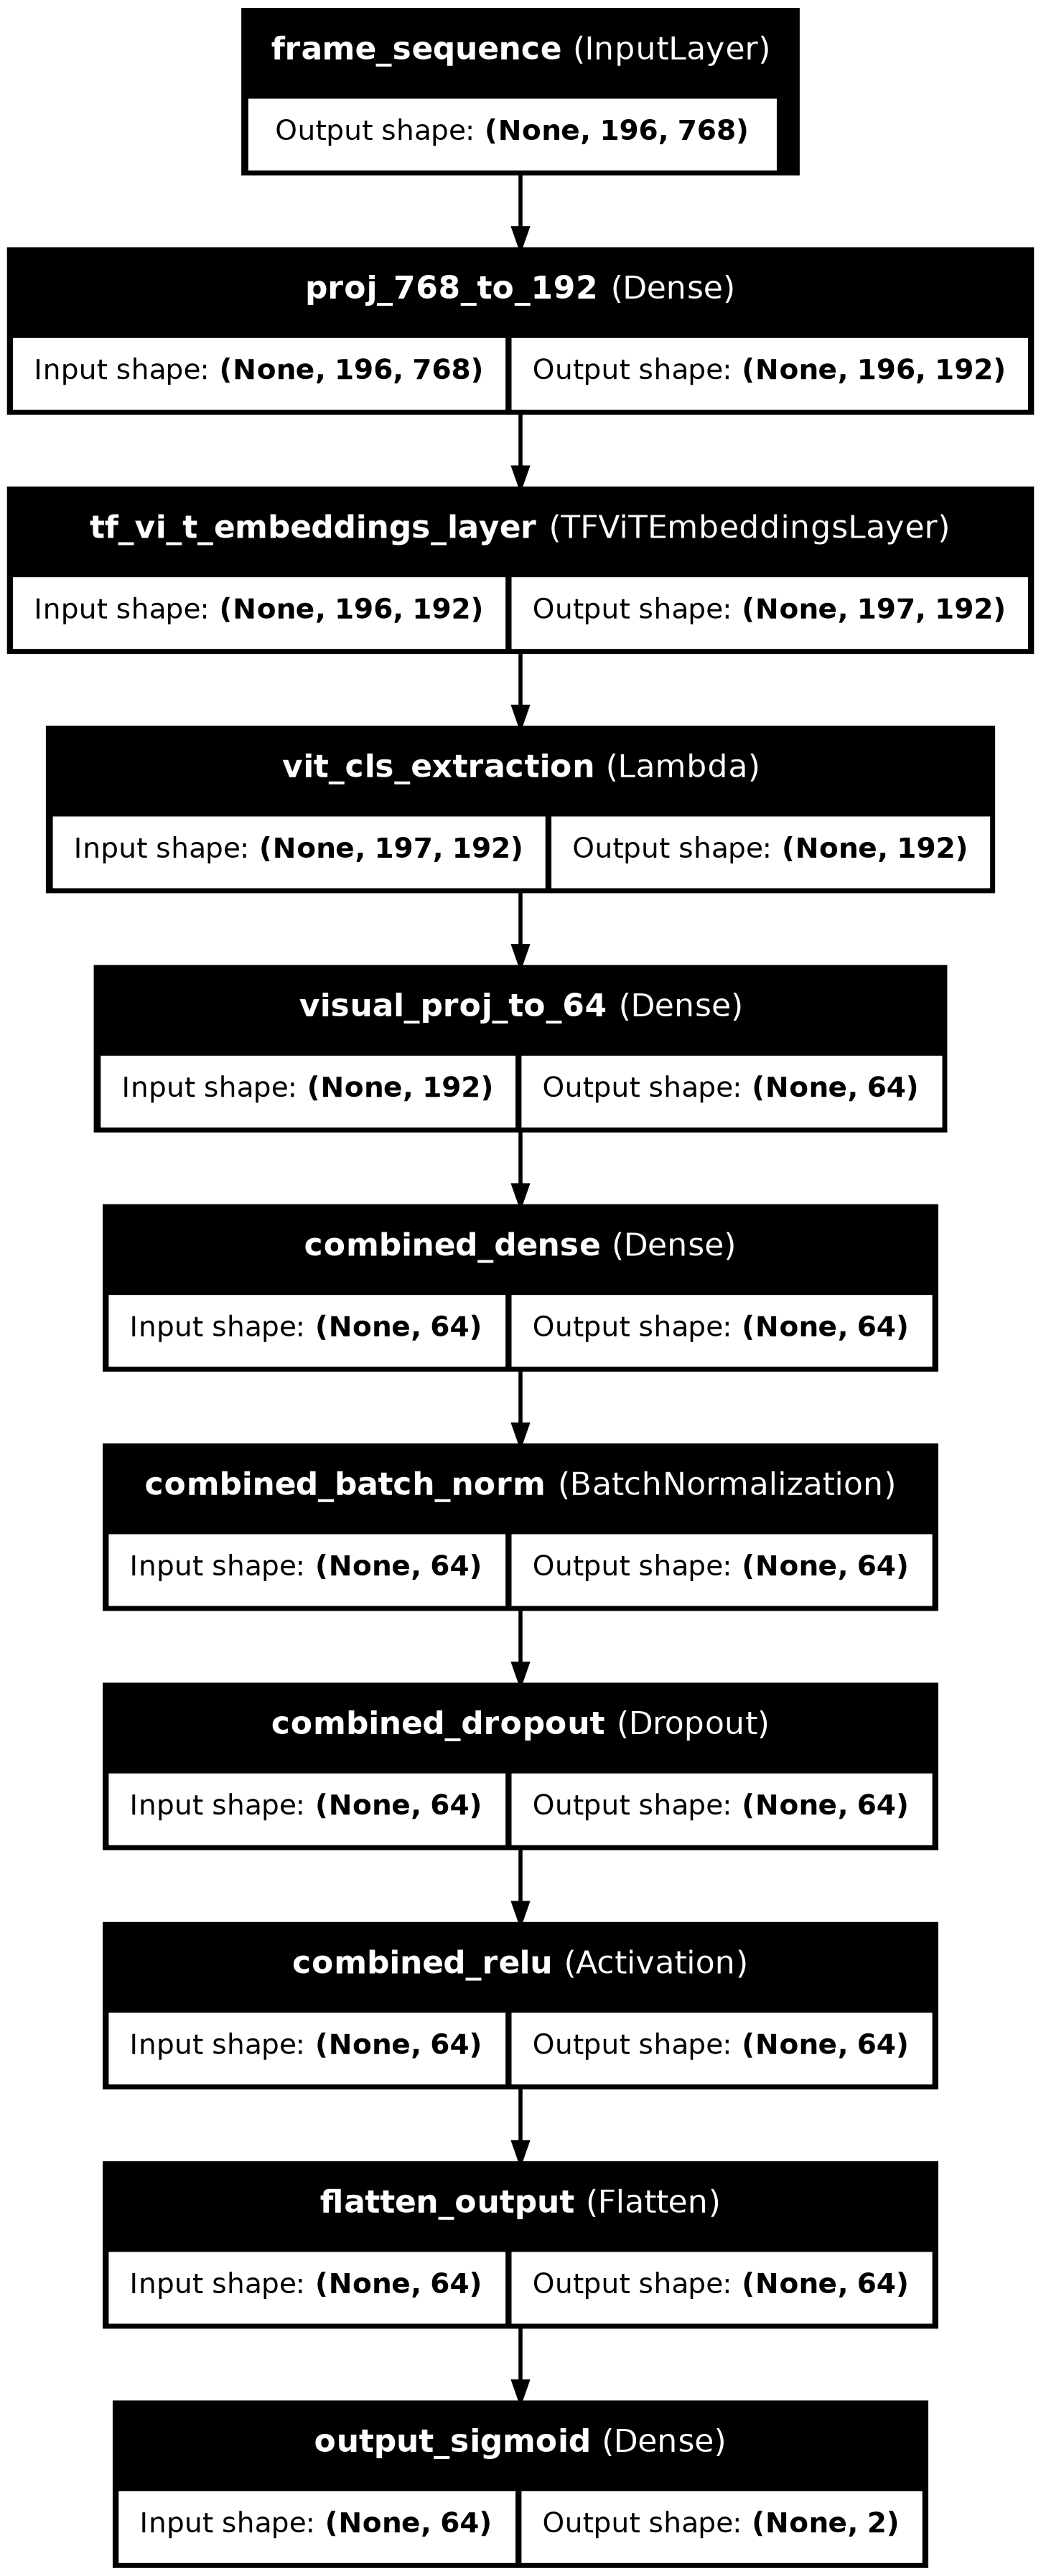

In [7]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [6]:
import numpy as np
import tensorflow as tf

# # Explicitly set GPU memory growth to avoid CUDA OOM errors
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)

# Load data
video_dataset = np.load('video_dataset.npy')  # shape: (num_samples, 196, 768)
video_targets = np.load('video_targets.npy')  # shape: (num_samples, 2)

# For demonstration, assuming dummy text_input (as it was missing),
# you need to replace it with actual loaded data if available
# text_input_dummy = np.zeros((video_dataset.shape[0], 768))

# Train-test split (optional for better evaluation)
from sklearn.model_selection import train_test_split

# video_dataset_train, video_dataset_val, video_targets_train, video_targets_val, text_input_train, text_input_val = train_test_split(
#     video_dataset, video_targets, text_input_dummy, test_size=0.2, random_state=42)
video_dataset_train, video_dataset_val, video_targets_train, video_targets_val = train_test_split(
    video_dataset, video_targets, test_size=0.2, random_state=42)

# Define initial hyperparameters
BATCH_SIZE = 4  # small batch due to small dataset
EPOCHS = 20

# Training
history = model.fit(
    # [video_dataset_train, text_input_train],
    [video_dataset_train],
    video_targets_train,
    # validation_data=([video_dataset_val, text_input_val], video_targets_val),
    validation_data=([video_dataset_val], video_targets_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True
)

# Optionally, evaluate the trained model
# loss, mse_metric = model.evaluate([video_dataset_val, text_input_val], video_targets_val)
loss, mse_metric = model.evaluate(video_dataset_val, video_targets_val)
print(f'Validation Loss: {loss}, Validation MSE: {mse_metric}')


Epoch 1/20


/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: frame_sequence
Received: inputs=('Tensor(shape=(None, 196, 768))',)
  warnings.warn(msg)
2025-04-16 14:36:55.114470: I external/local_xla/xla/service/service.cc:152] XLA service 0x76f974002fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-16 14:36:55.114494: I external/local_xla/xla/service/service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-04-16 14:36:55.298030: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1744799816.131085  148623 cuda_dnn.cc:520] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major ver

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/runpy.py", line 198, in _run_module_as_main

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/runpy.py", line 88, in _run_code

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3362, in run_cell_async

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3607, in run_ast_nodes

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code

  File "/tmp/ipykernel_148502/3071993588.py", line 31, in <module>

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/mhammed/anaconda3/envs/conda_vid_eval/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_23989]

In [1]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


2025-04-16 14:33:12.699395: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 14:33:12.730508: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-16 14:33:13.465604: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow Version: 2.20.0-dev20250413
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
model.save('final_model.keras')

In [ ]:
import tensorflow as tf

# Re-define your custom RMSE function exactly as defined before
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Load the model
loaded_model = tf.keras.models.load_model('final_model.keras', custom_objects={'rmse': rmse})

# Test inference
predictions = loaded_model.predict([visual_embedding_input, text_embedding_input])

In [5]:
import torch
import torch.nn as nn
from transformers import ViTModel

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit_base = ViTModel.from_pretrained('facebook/deit-tiny-patch16-224')

        self.visual_proj = nn.Sequential(
            nn.Linear(192, 64),
            nn.ReLU()
        )

        self.text_proj = nn.Sequential(
            nn.Linear(768, 64),
            nn.ReLU()
        )

        self.combined_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Sigmoid()
        )

    def forward(self, inputs_embeds, text_input):
        vit_outputs = self.vit_base(inputs_embeds=inputs_embeds)
        cls_output = vit_outputs.last_hidden_state[:, 0, :]

        visual_proj = self.visual_proj(cls_output)
        text_proj = self.text_proj(text_input)

        combined = torch.cat((visual_proj, text_proj), dim=1)
        output = self.combined_layers(combined)
        return output

# Example usage:
model = CustomModel()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# Dummy tensors:
batch_size = 4
inputs_embeds = torch.rand(batch_size, 196, 192)
text_input = torch.rand(batch_size, 768)
labels = torch.rand(batch_size, 2)

output = model(inputs_embeds, text_input)
loss = torch.sqrt(criterion(output, labels))

loss.backward()
optimizer.step()


Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: ViTModel.forward() got an unexpected keyword argument 'inputs_embeds'